In [1]:
from google.colab import files
uploaded = files.upload()

Saving VNM.csv to VNM.csv


In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import numpy.polynomial.polynomial as poly
import seaborn as sns
from datetime import datetime
from sklearn.utils import column_or_1d
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

In [148]:
df = pd.read_csv('VNM.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,3/1/2019,110654.0,112611.0,112611.0,110654.0,1.04M,0.21%
1,3/4/2019,111828.0,110732.0,112611.0,110732.0,1.05M,1.06%
2,3/5/2019,111124.0,111515.0,111750.0,110811.0,639.01K,-0.63%
3,3/6/2019,110341.0,111124.0,111750.0,108385.0,853.50K,-0.70%
4,3/7/2019,109324.0,110576.0,111124.0,109167.0,849.60K,-0.92%
...,...,...,...,...,...,...,...
1263,3/19/2024,67800.0,68500.0,68500.0,67800.0,3.16M,-0.15%
1264,3/20/2024,68000.0,67800.0,68600.0,67500.0,3.55M,0.29%
1265,3/21/2024,68400.0,68200.0,68500.0,67900.0,4.91M,0.59%
1266,3/22/2024,67800.0,69300.0,72500.0,67800.0,6.07M,-0.88%


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1268 non-null   object 
 1   Price     1268 non-null   float64
 2   Open      1268 non-null   float64
 3   High      1268 non-null   float64
 4   Low       1268 non-null   float64
 5   Vol.      1268 non-null   object 
 6   Change %  1268 non-null   object 
dtypes: float64(4), object(3)
memory usage: 69.5+ KB


<h1> Tien xu ly du lieu


In [150]:
df = df.dropna() # Drop missing values

In [151]:
df1 = df.reset_index()['Price']

In [152]:
df['Index'] = np.arange(len(df.index))

<h1> Scale du lieu


In [153]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

<h1>Split the data into training, testing, and validation sets (7:2:1)

In [154]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

In [155]:
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

<h1> Create dataset


In [156]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3...99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [157]:
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [158]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [159]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [160]:
#Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 107ms/step - loss: 0.1855 - val_loss: 0.0158
Epoch 2/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0238 - val_loss: 0.0397
Epoch 3/100
13/13 [==============================] - 1s 56ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 4/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0101 - val_loss: 0.0145
Epoch 5/100
13/13 [==============================] - 1s 56ms/step - loss: 0.0070 - val_loss: 0.0116
Epoch 6/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0051 - val_loss: 0.0066
Epoch 7/100
13/13 [==============================] - 1s 53ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 8/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 9/100
13/13 [==============================] - 1s 56ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 10/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0016 - val_loss: 6.986

<h1> Du bao du lieu test, val

In [161]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

1/1 [==============================] - 0s 30ms/step


In [162]:
#Chuan hoa du lieu cua y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [163]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[75900.],
       [75300.],
       [74700.],
       [76000.],
       [76500.],
       [76000.],
       [77500.],
       [77200.],
       [75500.],
       [75700.],
       [74700.],
       [75200.],
       [75500.],
       [76900.],
       [76500.],
       [76000.],
       [75000.],
       [75800.],
       [76500.],
       [76500.],
       [76900.],
       [76900.],
       [76600.],
       [77100.],
       [76400.],
       [74500.],
       [74300.],
       [74400.],
       [74400.],
       [75300.],
       [75000.],
       [74600.],
       [74400.],
       [74900.],
       [75000.],
       [74400.],
       [74400.],
       [74200.],
       [74500.],
       [74300.],
       [74700.],
       [74400.],
       [74400.],
       [74300.],
       [73500.],
       [72800.],
       [71700.],
       [73000.],
       [72000.],
       [71900.],
       [70900.],
       [70500.],
       [69900.],
       [71000.],
       [69500.],
       [70000.],
       [68600.],
       [68800.],
       [70400.

In [164]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[67600.],
       [70000.],
       [71900.],
       [71500.],
       [71300.],
       [71600.],
       [71300.],
       [71000.],
       [72000.],
       [72200.],
       [72000.],
       [71500.],
       [72000.],
       [73000.],
       [72200.],
       [72000.],
       [70000.],
       [70300.],
       [70000.],
       [70800.],
       [70500.],
       [68800.],
       [67900.],
       [67800.],
       [68000.],
       [68400.],
       [67800.]])

<h1>
Evaluate the accuracy of the algorithm

In [165]:
#Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 1060.618360277091
Testing RMSE: 946.9519831086845
Validation MAE: 768.2575231481482
Testing MAE: 719.2789884868422
Validation MAPE: 1.0932790931415561
Testing MAPE: 0.9899979181937514


<h1>Du doan co phieu trong 30 ngay tiep theo


In [166]:
x_input=val_data[28:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.12919822]
101
1 day input [0.13328416 0.1807451  0.19063279 0.17283494 0.19261033 0.18865525
 0.20052049 0.18667771 0.16492478 0.14712693 0.15108201 0.18667771
 0.17876756 0.17283494 0.15899217 0.16294725 0.16096971 0.14712693
 0.13921678 0.1352617  0.14317185 0.14119431 0.12141892 0.14119431
 0.14910447 0.1352617  0.14317185 0.14119431 0.15305955 0.17283494
 0.16096971 0.13723924 0.14119431 0.1352617  0.11350877 0.11350877
 0.1352617  0.12932908 0.125374   0.13130662 0.13328416 0.12339646
 0.14317185 0.125374   0.13921678 0.15305955 0.15305955 0.14910447
 0.13723924 0.1352617  0.12339646 0.13130662 0.11746385 0.11350877
 0.12141892 0.11548631 0.12141892 0.13328416 0.13921678 0.12735154
 0.11944138 0.11153123 0.11350877 0.11350877 0.11153123 0.11350877
 0.12339646 0.12141892 0.13328416 0.125374   0.125374   0.125374
 0.17283494 0.21040818 0.20249803 0.19854295 0.20447557 0.19854295
 0.19261033 0.21238572 0.2163408  0.21238572 0.20249803 0.21238572
 0.23216111 0.2163408  0.21238572 0

In [167]:
print(scaler.inverse_transform(lst_output))

[[67793.38283866]
 [67879.31129432]
 [67980.78789051]
 [68081.59837464]
 [68181.15500078]
 [68279.74938133]
 [68377.42823456]
 [68474.11470138]
 [68569.71534527]
 [68664.15556769]
 [68757.38262223]
 [68849.36486101]
 [68940.08721364]
 [69029.54440546]
 [69117.74623226]
 [69204.70173626]
 [69290.4229738 ]
 [69374.92727584]
 [69458.23272689]
 [69540.35138325]
 [69621.30359   ]
 [69701.11119921]
 [69779.78626721]
 [69857.3468785 ]
 [69933.81337813]
 [70009.1970689 ]
 [70083.51678883]
 [70156.79288296]
 [70229.03137946]
 [70300.25488394]]


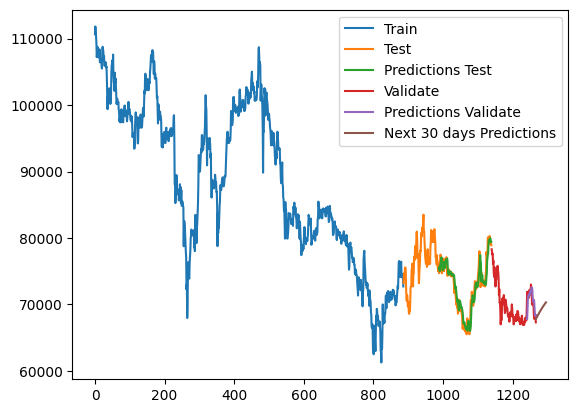

In [168]:
#Ve hinh
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions'])

plt.show()

<h1>Split the data into training, testing, and validation sets (6:3:1)

In [169]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

In [170]:
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

<h1>Create dataset

In [171]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3...99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [172]:
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [173]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [174]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [175]:
#Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 4s 162ms/step - loss: 0.1453 - val_loss: 0.0095
Epoch 2/100
11/11 [==============================] - 1s 97ms/step - loss: 0.0181 - val_loss: 0.0322
Epoch 3/100
11/11 [==============================] - 1s 90ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 4/100
11/11 [==============================] - 1s 59ms/step - loss: 0.0073 - val_loss: 0.0134
Epoch 5/100
11/11 [==============================] - 1s 68ms/step - loss: 0.0052 - val_loss: 0.0150
Epoch 6/100
11/11 [==============================] - 1s 63ms/step - loss: 0.0043 - val_loss: 0.0092
Epoch 7/100
11/11 [==============================] - 1s 57ms/step - loss: 0.0039 - val_loss: 0.0089
Epoch 8/100
11/11 [==============================] - 1s 59ms/step - loss: 0.0033 - val_loss: 0.0075
Epoch 9/100
11/11 [==============================] - 1s 58ms/step - loss: 0.0029 - val_loss: 0.0057
Epoch 10/100
11/11 [==============================] - 1s 61ms/step - loss: 0.0026 - val_loss: 0.004

<h1> Du bao du lieu test, val

In [176]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

1/1 [==============================] - 0s 48ms/step


In [177]:
#Chuan hoa du lieu cua y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [178]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[71324.7],
       [70931.7],
       [70735.2],
       [71226.5],
       [69851.1],
       [70637. ],
       [70244. ],
       [70538.8],
       [71324.7],
       [72110.7],
       [72798.4],
       [72405.4],
       [74468.5],
       [76335.1],
       [76531.6],
       [75549.2],
       [74173.8],
       [74665. ],
       [74173.8],
       [76138.6],
       [76433.4],
       [74370.3],
       [74370.3],
       [74566.7],
       [73977.3],
       [74370.3],
       [72700.1],
       [73191.3],
       [74665. ],
       [73879. ],
       [74468.5],
       [75549.2],
       [75549.2],
       [75352.7],
       [72700.1],
       [71128.2],
       [70538.8],
       [71423. ],
       [71030. ],
       [69752.8],
       [69654.6],
       [70342.3],
       [68770.4],
       [68573.9],
       [69261.6],
       [68966.9],
       [70342.3],
       [72503.6],
       [72700.1],
       [72798.4],
       [75156.2],
       [75254.4],
       [76138.6],
       [75647.4],
       [72700.1],
       [74

In [179]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[67600.],
       [70000.],
       [71900.],
       [71500.],
       [71300.],
       [71600.],
       [71300.],
       [71000.],
       [72000.],
       [72200.],
       [72000.],
       [71500.],
       [72000.],
       [73000.],
       [72200.],
       [72000.],
       [70000.],
       [70300.],
       [70000.],
       [70800.],
       [70500.],
       [68800.],
       [67900.],
       [67800.],
       [68000.],
       [68400.],
       [67800.]])

<h1>Evaluate the accuracy of the algorithm




In [180]:
#Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 1162.260655247328
Testing RMSE: 1192.7994476085223
Validation MAE: 886.7375578703703
Testing MAE: 945.7120015681004
Validation MAPE: 1.2656252442428655
Testing MAPE: 1.2764714090049811


<h1>Du doan co phieu trong 30 ngay tiep theo

In [181]:
x_input=val_data[28:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.13553704]
101
1 day input [0.13328416 0.1807451  0.19063279 0.17283494 0.19261033 0.18865525
 0.20052049 0.18667771 0.16492478 0.14712693 0.15108201 0.18667771
 0.17876756 0.17283494 0.15899217 0.16294725 0.16096971 0.14712693
 0.13921678 0.1352617  0.14317185 0.14119431 0.12141892 0.14119431
 0.14910447 0.1352617  0.14317185 0.14119431 0.15305955 0.17283494
 0.16096971 0.13723924 0.14119431 0.1352617  0.11350877 0.11350877
 0.1352617  0.12932908 0.125374   0.13130662 0.13328416 0.12339646
 0.14317185 0.125374   0.13921678 0.15305955 0.15305955 0.14910447
 0.13723924 0.1352617  0.12339646 0.13130662 0.11746385 0.11350877
 0.12141892 0.11548631 0.12141892 0.13328416 0.13921678 0.12735154
 0.11944138 0.11153123 0.11350877 0.11350877 0.11153123 0.11350877
 0.12339646 0.12141892 0.13328416 0.125374   0.125374   0.125374
 0.17283494 0.21040818 0.20249803 0.19854295 0.20447557 0.19854295
 0.19261033 0.21238572 0.2163408  0.21238572 0.20249803 0.21238572
 0.23216111 0.2163408  0.21238572 0

In [182]:
print(scaler.inverse_transform(lst_output))

[[68113.92364753]
 [68300.11327093]
 [68527.21151842]
 [68756.77754532]
 [68986.29082579]
 [69215.83047948]
 [69445.3309501 ]
 [69674.49987173]
 [69902.99213202]
 [70130.47166085]
 [70356.65438102]
 [70581.30218008]
 [70804.23948776]
 [71025.31635351]
 [71244.44235486]
 [71461.53761866]
 [71676.55165903]
 [71889.45056756]
 [72100.21776679]
 [72308.84496801]
 [72515.33292472]
 [72719.68615806]
 [72921.91823139]
 [73122.05024329]
 [73320.09425008]
 [73516.07813201]
 [73710.01846654]
 [73901.94690153]
 [74091.88378202]
 [74279.85849531]]


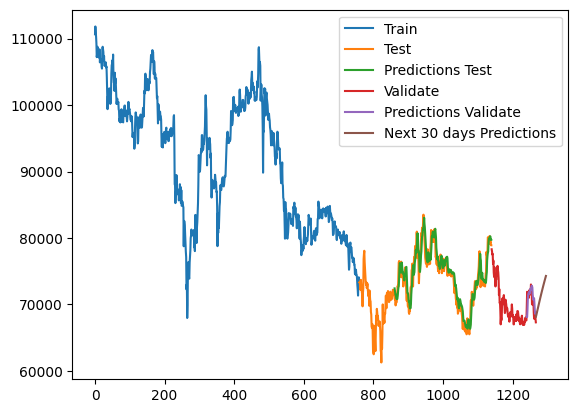

In [183]:
#Ve hinh
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions'])

plt.show()

<h1>Split the data into training, testing, and validation sets (5:3:2)

In [184]:
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

In [185]:
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

<h1> Create dataset

In [186]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3...99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [187]:
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [188]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [189]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [190]:
#Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 4s 163ms/step - loss: 0.2705 - val_loss: 0.0036
Epoch 2/100
9/9 [==============================] - 1s 103ms/step - loss: 0.0220 - val_loss: 0.0571
Epoch 3/100
9/9 [==============================] - 1s 106ms/step - loss: 0.0235 - val_loss: 0.0280
Epoch 4/100
9/9 [==============================] - 1s 102ms/step - loss: 0.0064 - val_loss: 0.0125
Epoch 5/100
9/9 [==============================] - 1s 60ms/step - loss: 0.0077 - val_loss: 0.0158
Epoch 6/100
9/9 [==============================] - 1s 62ms/step - loss: 0.0051 - val_loss: 0.0220
Epoch 7/100
9/9 [==============================] - 1s 61ms/step - loss: 0.0050 - val_loss: 0.0185
Epoch 8/100
9/9 [==============================] - 1s 62ms/step - loss: 0.0044 - val_loss: 0.0141
Epoch 9/100
9/9 [==============================] - 1s 59ms/step - loss: 0.0042 - val_loss: 0.0140
Epoch 10/100
9/9 [==============================] - 1s 61ms/step - loss: 0.0038 - val_loss: 0.0136
Epoch 11/100
9/

<h1>Du bao du lieu test, val

In [191]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

5/5 [==============================] - 0s 11ms/step


In [192]:
#Chuan hoa du lieu cua y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [193]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[79305.7],
       [77881. ],
       [78640.9],
       [78545.9],
       [77881. ],
       [77026.2],
       [77121.2],
       [76361.4],
       [76741.3],
       [76551.4],
       [76931.3],
       [75981.5],
       [75981.5],
       [74651.8],
       [74936.8],
       [74461.9],
       [75221.7],
       [74556.8],
       [74461.9],
       [73987. ],
       [72942.2],
       [72277.4],
       [71327.6],
       [73227.2],
       [74082. ],
       [73322.1],
       [73322.1],
       [73417.1],
       [72562.3],
       [72182.4],
       [73702.1],
       [73037.2],
       [72277.4],
       [71802.5],
       [71422.6],
       [69713. ],
       [71707.5],
       [72372.4],
       [76836.3],
       [77596.1],
       [78071. ],
       [76361.4],
       [75316.7],
       [74556.8],
       [73417.1],
       [72942.2],
       [73322.1],
       [72467.4],
       [72657.3],
       [73132.2],
       [72182.4],
       [71802.5],
       [71232.7],
       [72087.4],
       [69808. ],
       [72

In [194]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[73500.],
       [73400.],
       [72800.],
       [73100.],
       [73600.],
       [73300.],
       [72900.],
       [72700.],
       [73500.],
       [74700.],
       [74900.],
       [77900.],
       [77400.],
       [77800.],
       [77800.],
       [80100.],
       [80000.],
       [79500.],
       [80000.],
       [79500.],
       [80300.],
       [79100.],
       [79400.],
       [79500.],
       [78900.],
       [78900.],
       [78300.],
       [78000.],
       [77500.],
       [77600.],
       [76100.],
       [76600.],
       [74800.],
       [74200.],
       [75600.],
       [74000.],
       [74400.],
       [72700.],
       [74200.],
       [73700.],
       [74400.],
       [74400.],
       [75500.],
       [75800.],
       [75200.],
       [74800.],
       [73900.],
       [71400.],
       [72300.],
       [70200.],
       [70300.],
       [69000.],
       [67000.],
       [68000.],
       [67600.],
       [68000.],
       [70400.],
       [70900.],
       [70000.

<h1>Evaluate the accuracy of the algorithm

In [195]:
#Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 1256.6320150457097
Testing RMSE: 1507.9599027860481
Validation MAE: 1018.7769607843137
Testing MAE: 1199.0452480958784
Validation MAPE: 1.4443533309663628
Testing MAPE: 1.6543491521155036


<h1>Du doan co phieu trong 30 ngay tiep theo

In [266]:
x_input=val_data[147:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1




0 day input [0.21831834 0.17679002 0.17876756 0.15305955 0.11350877 0.13328416
 0.125374   0.13328416 0.1807451  0.19063279 0.17283494 0.19261033
 0.18865525 0.20052049 0.18667771 0.16492478 0.14712693 0.15108201
 0.18667771 0.17876756 0.17283494 0.15899217 0.16294725 0.16096971
 0.14712693 0.13921678 0.1352617  0.14317185 0.14119431 0.12141892
 0.14119431 0.14910447 0.1352617  0.14317185 0.14119431 0.15305955
 0.17283494 0.16096971 0.13723924 0.14119431 0.1352617  0.11350877
 0.11350877 0.1352617  0.12932908 0.125374   0.13130662 0.13328416
 0.12339646 0.14317185 0.125374   0.13921678 0.15305955 0.15305955
 0.14910447 0.13723924 0.1352617  0.12339646 0.13130662 0.11746385
 0.11350877 0.12141892 0.11548631 0.12141892 0.13328416 0.13921678
 0.12735154 0.11944138 0.11153123 0.11350877 0.11350877 0.11153123
 0.11350877 0.12339646 0.12141892 0.13328416 0.125374   0.125374
 0.125374   0.17283494 0.21040818 0.20249803 0.19854295 0.20447557
 0.19854295 0.19261033 0.21238572 0.2163408  0.21238

In [267]:
print(scaler.inverse_transform(lst_output))

[[68580.50952542]
 [68878.78832673]
 [69210.57467448]
 [69550.32271909]
 [69888.24423018]
 [70221.32964715]
 [70548.88347066]
 [70870.81151064]
 [71187.1326051 ]
 [71497.88367656]
 [71803.08356301]
 [72102.76767992]
 [72396.97068923]
 [72685.7498585 ]
 [72969.16697638]
 [73247.29438086]
 [73520.21420565]
 [73788.01159856]
 [74050.77622853]
 [74308.59927152]
 [74561.57717815]
 [74809.804892  ]
 [75053.38037072]
 [75292.39855788]
 [75526.95289002]
 [75757.14283183]
 [75983.06031281]
 [76204.79876949]
 [76422.43958208]
 [76636.08372231]]


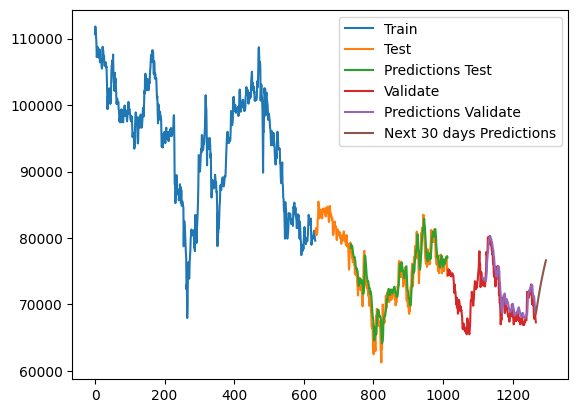

In [268]:
#Ve hinh
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions'])

plt.show()